# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [33]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [34]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [35]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [36]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
print(grad)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

[ 0.57611688 -0.78805844  0.21194156]
Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [37]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [38]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [39]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [50]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e-4)

Epoch 0, loss: 2.302514
Epoch 1, loss: 2.300453
Epoch 2, loss: 2.299654
Epoch 3, loss: 2.299895
Epoch 4, loss: 2.298889
Epoch 5, loss: 2.297709
Epoch 6, loss: 2.296624
Epoch 7, loss: 2.295108
Epoch 8, loss: 2.295128
Epoch 9, loss: 2.298795


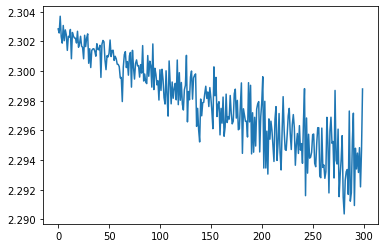

In [51]:
# let's look at the loss history!
plt.plot(loss_history)

In [52]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-4, batch_size=300, reg=1e-3)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.149
Epoch 0, loss: 2.295690
Epoch 1, loss: 2.293803
Epoch 2, loss: 2.293050
Epoch 3, loss: 2.294839
Epoch 4, loss: 2.296789
Epoch 5, loss: 2.290313
Epoch 6, loss: 2.294210
Epoch 7, loss: 2.294278
Epoch 8, loss: 2.290534
Epoch 9, loss: 2.294521
Epoch 10, loss: 2.296582
Epoch 11, loss: 2.290158
Epoch 12, loss: 2.293191
Epoch 13, loss: 2.290942
Epoch 14, loss: 2.291905
Epoch 15, loss: 2.290403
Epoch 16, loss: 2.300051
Epoch 17, loss: 2.289904
Epoch 18, loss: 2.292377
Epoch 19, loss: 2.292721
Epoch 20, loss: 2.293003
Epoch 21, loss: 2.288974
Epoch 22, loss: 2.292463
Epoch 23, loss: 2.289662
Epoch 24, loss: 2.289399
Epoch 25, loss: 2.289688
Epoch 26, loss: 2.290271
Epoch 27, loss: 2.291511
Epoch 28, loss: 2.290564
Epoch 29, loss: 2.295614
Epoch 30, loss: 2.290160
Epoch 31, loss: 2.292343
Epoch 32, loss: 2.285731
Epoch 33, loss: 2.287933
Epoch 34, loss: 2.287906
Epoch 35, loss: 2.293190
Epoch 36, loss: 2.291278
Epoch 37, loss: 2.292582
Epoch 38, loss: 2.287705
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [53]:
%%time
from itertools import product

num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
reg_strengths = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

for learning_rate, reg_strength in product(learning_rates, reg_strengths):
    classifier.fit(train_X, train_y, 
                   epochs=num_epochs, 
                   learning_rate=learning_rate, 
                   batch_size=batch_size, 
                   reg=reg_strength)
    
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    
    if accuracy > best_val_accuracy:
        best_classifier = classifier
        best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.285168
Epoch 1, loss: 2.271419
Epoch 2, loss: 2.270707
Epoch 3, loss: 2.262261
Epoch 4, loss: 2.262990
Epoch 5, loss: 2.249987
Epoch 6, loss: 2.261180
Epoch 7, loss: 2.257675
Epoch 8, loss: 2.248616
Epoch 9, loss: 2.210346
Epoch 10, loss: 2.261705
Epoch 11, loss: 2.235455
Epoch 12, loss: 2.223435
Epoch 13, loss: 2.206445
Epoch 14, loss: 2.231597
Epoch 15, loss: 2.216450
Epoch 16, loss: 2.247247
Epoch 17, loss: 2.204278
Epoch 18, loss: 2.219121
Epoch 19, loss: 2.189738
Epoch 20, loss: 2.205052
Epoch 21, loss: 2.210366
Epoch 22, loss: 2.157442
Epoch 23, loss: 2.234750
Epoch 24, loss: 2.207523
Epoch 25, loss: 2.217943
Epoch 26, loss: 2.171520
Epoch 27, loss: 2.217665
Epoch 28, loss: 2.177789
Epoch 29, loss: 2.184020
Epoch 30, loss: 2.215240
Epoch 31, loss: 2.186128
Epoch 32, loss: 2.171908
Epoch 33, loss: 2.184550
Epoch 34, loss: 2.202303
Epoch 35, loss: 2.181694
Epoch 36, loss: 2.176689
Epoch 37, loss: 2.213941
Epoch 38, loss: 2.158520
Epoch 39, loss: 2.195520
Epoch 40, 

Epoch 124, loss: 2.085810
Epoch 125, loss: 2.114730
Epoch 126, loss: 2.116627
Epoch 127, loss: 2.120878
Epoch 128, loss: 2.065833
Epoch 129, loss: 2.112362
Epoch 130, loss: 2.044979
Epoch 131, loss: 2.114932
Epoch 132, loss: 2.095956
Epoch 133, loss: 2.063340
Epoch 134, loss: 2.075794
Epoch 135, loss: 2.057136
Epoch 136, loss: 2.072849
Epoch 137, loss: 2.129786
Epoch 138, loss: 2.079231
Epoch 139, loss: 2.095540
Epoch 140, loss: 2.097215
Epoch 141, loss: 2.093353
Epoch 142, loss: 2.200364
Epoch 143, loss: 2.081639
Epoch 144, loss: 2.132144
Epoch 145, loss: 2.132493
Epoch 146, loss: 2.094415
Epoch 147, loss: 2.120907
Epoch 148, loss: 2.059223
Epoch 149, loss: 2.102017
Epoch 150, loss: 2.106110
Epoch 151, loss: 2.066864
Epoch 152, loss: 2.117659
Epoch 153, loss: 2.138370
Epoch 154, loss: 2.070406
Epoch 155, loss: 2.119584
Epoch 156, loss: 2.100486
Epoch 157, loss: 2.112015
Epoch 158, loss: 2.177872
Epoch 159, loss: 2.053118
Epoch 160, loss: 2.090999
Epoch 161, loss: 2.065490
Epoch 162, l

Epoch 46, loss: 2.046658
Epoch 47, loss: 2.042001
Epoch 48, loss: 2.010314
Epoch 49, loss: 2.111066
Epoch 50, loss: 2.086657
Epoch 51, loss: 2.066525
Epoch 52, loss: 2.036359
Epoch 53, loss: 2.088297
Epoch 54, loss: 2.066460
Epoch 55, loss: 2.119258
Epoch 56, loss: 2.072853
Epoch 57, loss: 2.048448
Epoch 58, loss: 1.993296
Epoch 59, loss: 2.011940
Epoch 60, loss: 2.065883
Epoch 61, loss: 2.015961
Epoch 62, loss: 2.082651
Epoch 63, loss: 2.106457
Epoch 64, loss: 2.083829
Epoch 65, loss: 1.974776
Epoch 66, loss: 1.969892
Epoch 67, loss: 2.107210
Epoch 68, loss: 2.033682
Epoch 69, loss: 2.074984
Epoch 70, loss: 2.049074
Epoch 71, loss: 2.089122
Epoch 72, loss: 2.094464
Epoch 73, loss: 2.012153
Epoch 74, loss: 2.068337
Epoch 75, loss: 2.093711
Epoch 76, loss: 2.069529
Epoch 77, loss: 2.059660
Epoch 78, loss: 1.993350
Epoch 79, loss: 2.119395
Epoch 80, loss: 2.102058
Epoch 81, loss: 2.080965
Epoch 82, loss: 2.105992
Epoch 83, loss: 2.052804
Epoch 84, loss: 2.063599
Epoch 85, loss: 1.978547


Epoch 168, loss: 2.053846
Epoch 169, loss: 2.055185
Epoch 170, loss: 2.091071
Epoch 171, loss: 2.035123
Epoch 172, loss: 1.990218
Epoch 173, loss: 2.059378
Epoch 174, loss: 2.061413
Epoch 175, loss: 2.072909
Epoch 176, loss: 2.019999
Epoch 177, loss: 2.077556
Epoch 178, loss: 2.014865
Epoch 179, loss: 2.055076
Epoch 180, loss: 1.987734
Epoch 181, loss: 2.053599
Epoch 182, loss: 2.055261
Epoch 183, loss: 2.095272
Epoch 184, loss: 1.999701
Epoch 185, loss: 2.007102
Epoch 186, loss: 2.080584
Epoch 187, loss: 2.007527
Epoch 188, loss: 2.069007
Epoch 189, loss: 2.010984
Epoch 190, loss: 2.081706
Epoch 191, loss: 2.089057
Epoch 192, loss: 1.976680
Epoch 193, loss: 2.075425
Epoch 194, loss: 1.983146
Epoch 195, loss: 2.055439
Epoch 196, loss: 2.053199
Epoch 197, loss: 2.069455
Epoch 198, loss: 2.025020
Epoch 199, loss: 1.997724
Epoch 0, loss: 2.361012
Epoch 1, loss: 2.284807
Epoch 2, loss: 2.305879
Epoch 3, loss: 2.332668
Epoch 4, loss: 2.374119
Epoch 5, loss: 2.390453
Epoch 6, loss: 2.378630


Epoch 92, loss: 2.083606
Epoch 93, loss: 2.119156
Epoch 94, loss: 2.048427
Epoch 95, loss: 2.027708
Epoch 96, loss: 2.089748
Epoch 97, loss: 2.049507
Epoch 98, loss: 2.060760
Epoch 99, loss: 2.080963
Epoch 100, loss: 2.133329
Epoch 101, loss: 2.055197
Epoch 102, loss: 2.063068
Epoch 103, loss: 2.050105
Epoch 104, loss: 2.076127
Epoch 105, loss: 2.084997
Epoch 106, loss: 2.073994
Epoch 107, loss: 2.014346
Epoch 108, loss: 2.033429
Epoch 109, loss: 1.964940
Epoch 110, loss: 2.132011
Epoch 111, loss: 2.046804
Epoch 112, loss: 2.019180
Epoch 113, loss: 2.094604
Epoch 114, loss: 2.126104
Epoch 115, loss: 2.005533
Epoch 116, loss: 2.029439
Epoch 117, loss: 2.079036
Epoch 118, loss: 2.061669
Epoch 119, loss: 2.049780
Epoch 120, loss: 2.095426
Epoch 121, loss: 2.085122
Epoch 122, loss: 2.071637
Epoch 123, loss: 2.073434
Epoch 124, loss: 2.067980
Epoch 125, loss: 1.998428
Epoch 126, loss: 2.100017
Epoch 127, loss: 2.092357
Epoch 128, loss: 2.096959
Epoch 129, loss: 2.157110
Epoch 130, loss: 2.0

Epoch 13, loss: 2.056944
Epoch 14, loss: 2.007717
Epoch 15, loss: 1.992828
Epoch 16, loss: 2.024892
Epoch 17, loss: 2.002607
Epoch 18, loss: 2.062051
Epoch 19, loss: 2.085609
Epoch 20, loss: 2.033510
Epoch 21, loss: 2.043155
Epoch 22, loss: 2.005516
Epoch 23, loss: 2.080236
Epoch 24, loss: 2.041981
Epoch 25, loss: 2.071302
Epoch 26, loss: 2.022769
Epoch 27, loss: 2.074947
Epoch 28, loss: 2.049512
Epoch 29, loss: 2.030672
Epoch 30, loss: 2.038924
Epoch 31, loss: 2.017362
Epoch 32, loss: 2.080281
Epoch 33, loss: 2.041288
Epoch 34, loss: 2.057452
Epoch 35, loss: 1.994279
Epoch 36, loss: 2.005374
Epoch 37, loss: 2.016931
Epoch 38, loss: 2.017627
Epoch 39, loss: 2.023826
Epoch 40, loss: 2.046221
Epoch 41, loss: 2.035324
Epoch 42, loss: 2.009193
Epoch 43, loss: 1.961856
Epoch 44, loss: 2.046424
Epoch 45, loss: 2.065958
Epoch 46, loss: 2.013178
Epoch 47, loss: 1.994628
Epoch 48, loss: 2.041990
Epoch 49, loss: 2.008271
Epoch 50, loss: 2.053689
Epoch 51, loss: 2.065717
Epoch 52, loss: 2.028022


Epoch 136, loss: 2.034678
Epoch 137, loss: 2.008472
Epoch 138, loss: 2.085018
Epoch 139, loss: 2.007995
Epoch 140, loss: 2.132078
Epoch 141, loss: 2.034346
Epoch 142, loss: 1.982303
Epoch 143, loss: 2.131928
Epoch 144, loss: 2.068018
Epoch 145, loss: 2.025631
Epoch 146, loss: 1.990287
Epoch 147, loss: 2.060688
Epoch 148, loss: 2.059807
Epoch 149, loss: 2.016831
Epoch 150, loss: 2.140881
Epoch 151, loss: 2.012308
Epoch 152, loss: 2.073207
Epoch 153, loss: 1.974824
Epoch 154, loss: 2.030250
Epoch 155, loss: 2.044546
Epoch 156, loss: 2.033192
Epoch 157, loss: 2.036667
Epoch 158, loss: 2.083334
Epoch 159, loss: 2.067720
Epoch 160, loss: 2.049711
Epoch 161, loss: 2.032956
Epoch 162, loss: 2.131236
Epoch 163, loss: 2.085342
Epoch 164, loss: 2.034504
Epoch 165, loss: 2.086379
Epoch 166, loss: 2.021590
Epoch 167, loss: 1.992448
Epoch 168, loss: 2.085482
Epoch 169, loss: 2.040826
Epoch 170, loss: 1.998714
Epoch 171, loss: 2.000383
Epoch 172, loss: 2.004663
Epoch 173, loss: 2.052455
Epoch 174, l

Epoch 58, loss: 2.093552
Epoch 59, loss: 2.044779
Epoch 60, loss: 2.097251
Epoch 61, loss: 2.087980
Epoch 62, loss: 2.089273
Epoch 63, loss: 2.122008
Epoch 64, loss: 1.980617
Epoch 65, loss: 2.039772
Epoch 66, loss: 2.086811
Epoch 67, loss: 2.061879
Epoch 68, loss: 2.068867
Epoch 69, loss: 2.068519
Epoch 70, loss: 2.115904
Epoch 71, loss: 2.086623
Epoch 72, loss: 2.035608
Epoch 73, loss: 1.951461
Epoch 74, loss: 2.072249
Epoch 75, loss: 2.091673
Epoch 76, loss: 2.031490
Epoch 77, loss: 2.108619
Epoch 78, loss: 2.052866
Epoch 79, loss: 2.030960
Epoch 80, loss: 2.098199
Epoch 81, loss: 2.054520
Epoch 82, loss: 2.062556
Epoch 83, loss: 2.022206
Epoch 84, loss: 2.040400
Epoch 85, loss: 2.064697
Epoch 86, loss: 2.131063
Epoch 87, loss: 2.056029
Epoch 88, loss: 2.031449
Epoch 89, loss: 2.093070
Epoch 90, loss: 2.103923
Epoch 91, loss: 2.033187
Epoch 92, loss: 2.022161
Epoch 93, loss: 2.023930
Epoch 94, loss: 2.056252
Epoch 95, loss: 2.095025
Epoch 96, loss: 2.092547
Epoch 97, loss: 2.111206


Epoch 179, loss: 1.979814
Epoch 180, loss: 2.036319
Epoch 181, loss: 2.073686
Epoch 182, loss: 2.011304
Epoch 183, loss: 2.055225
Epoch 184, loss: 2.080073
Epoch 185, loss: 1.983857
Epoch 186, loss: 2.039736
Epoch 187, loss: 2.048712
Epoch 188, loss: 2.031933
Epoch 189, loss: 2.037013
Epoch 190, loss: 2.011283
Epoch 191, loss: 2.083520
Epoch 192, loss: 1.986172
Epoch 193, loss: 2.035069
Epoch 194, loss: 2.076165
Epoch 195, loss: 2.051885
Epoch 196, loss: 2.034306
Epoch 197, loss: 2.020872
Epoch 198, loss: 2.073000
Epoch 199, loss: 1.979842
Epoch 0, loss: 2.052341
Epoch 1, loss: 2.055559
Epoch 2, loss: 2.016738
Epoch 3, loss: 2.022571
Epoch 4, loss: 1.968902
Epoch 5, loss: 2.043628
Epoch 6, loss: 2.081881
Epoch 7, loss: 1.931105
Epoch 8, loss: 2.098653
Epoch 9, loss: 2.045356
Epoch 10, loss: 2.038975
Epoch 11, loss: 2.017631
Epoch 12, loss: 2.045944
Epoch 13, loss: 1.995062
Epoch 14, loss: 2.078143
Epoch 15, loss: 2.010681
Epoch 16, loss: 2.017699
Epoch 17, loss: 2.051055
Epoch 18, loss

Epoch 103, loss: 2.020008
Epoch 104, loss: 2.001738
Epoch 105, loss: 2.025019
Epoch 106, loss: 2.068424
Epoch 107, loss: 2.068189
Epoch 108, loss: 2.043306
Epoch 109, loss: 2.032659
Epoch 110, loss: 2.014087
Epoch 111, loss: 2.058811
Epoch 112, loss: 2.048084
Epoch 113, loss: 2.075406
Epoch 114, loss: 2.023273
Epoch 115, loss: 2.091227
Epoch 116, loss: 1.971327
Epoch 117, loss: 2.041821
Epoch 118, loss: 1.998551
Epoch 119, loss: 2.004328
Epoch 120, loss: 2.066240
Epoch 121, loss: 2.001716
Epoch 122, loss: 2.113994
Epoch 123, loss: 2.050347
Epoch 124, loss: 2.036749
Epoch 125, loss: 1.992856
Epoch 126, loss: 2.096115
Epoch 127, loss: 2.062777
Epoch 128, loss: 1.988520
Epoch 129, loss: 2.098061
Epoch 130, loss: 2.032995
Epoch 131, loss: 2.092275
Epoch 132, loss: 2.024350
Epoch 133, loss: 2.016651
Epoch 134, loss: 1.984966
Epoch 135, loss: 1.976737
Epoch 136, loss: 2.040617
Epoch 137, loss: 2.060312
Epoch 138, loss: 2.016196
Epoch 139, loss: 2.063525
Epoch 140, loss: 2.048543
Epoch 141, l

Epoch 24, loss: 2.074536
Epoch 25, loss: 2.080825
Epoch 26, loss: 2.071235
Epoch 27, loss: 2.028285
Epoch 28, loss: 2.156697
Epoch 29, loss: 1.977103
Epoch 30, loss: 2.057106
Epoch 31, loss: 2.092136
Epoch 32, loss: 2.091486
Epoch 33, loss: 2.140516
Epoch 34, loss: 2.060157
Epoch 35, loss: 2.062707
Epoch 36, loss: 2.101265
Epoch 37, loss: 2.055568
Epoch 38, loss: 2.026503
Epoch 39, loss: 2.105713
Epoch 40, loss: 2.060918
Epoch 41, loss: 2.061909
Epoch 42, loss: 2.095619
Epoch 43, loss: 2.110664
Epoch 44, loss: 2.071247
Epoch 45, loss: 2.126077
Epoch 46, loss: 2.034174
Epoch 47, loss: 2.049203
Epoch 48, loss: 2.068082
Epoch 49, loss: 2.077648
Epoch 50, loss: 2.062215
Epoch 51, loss: 2.103200
Epoch 52, loss: 1.993157
Epoch 53, loss: 2.025327
Epoch 54, loss: 2.109902
Epoch 55, loss: 2.027187
Epoch 56, loss: 2.068116
Epoch 57, loss: 2.090704
Epoch 58, loss: 2.065273
Epoch 59, loss: 2.015614
Epoch 60, loss: 2.099951
Epoch 61, loss: 2.068426
Epoch 62, loss: 2.044613
Epoch 63, loss: 2.047817


Epoch 147, loss: 2.061656
Epoch 148, loss: 2.130466
Epoch 149, loss: 2.098074
Epoch 150, loss: 1.987986
Epoch 151, loss: 2.024721
Epoch 152, loss: 2.062448
Epoch 153, loss: 2.142163
Epoch 154, loss: 1.996595
Epoch 155, loss: 2.065957
Epoch 156, loss: 2.004835
Epoch 157, loss: 2.022639
Epoch 158, loss: 2.004380
Epoch 159, loss: 2.052379
Epoch 160, loss: 2.028573
Epoch 161, loss: 2.065625
Epoch 162, loss: 2.036647
Epoch 163, loss: 2.040231
Epoch 164, loss: 2.007427
Epoch 165, loss: 2.038056
Epoch 166, loss: 2.028728
Epoch 167, loss: 2.099113
Epoch 168, loss: 2.050560
Epoch 169, loss: 2.076327
Epoch 170, loss: 2.035322
Epoch 171, loss: 1.997930
Epoch 172, loss: 2.139871
Epoch 173, loss: 2.035548
Epoch 174, loss: 2.021576
Epoch 175, loss: 2.033340
Epoch 176, loss: 2.093841
Epoch 177, loss: 2.041532
Epoch 178, loss: 2.041284
Epoch 179, loss: 2.086389
Epoch 180, loss: 2.076452
Epoch 181, loss: 2.077316
Epoch 182, loss: 2.045182
Epoch 183, loss: 2.062411
Epoch 184, loss: 2.066959
Epoch 185, l

Epoch 70, loss: 2.001375
Epoch 71, loss: 2.023295
Epoch 72, loss: 2.080027
Epoch 73, loss: 2.051693
Epoch 74, loss: 2.025978
Epoch 75, loss: 2.049956
Epoch 76, loss: 2.043443
Epoch 77, loss: 2.006075
Epoch 78, loss: 2.062744
Epoch 79, loss: 2.074109
Epoch 80, loss: 2.014869
Epoch 81, loss: 2.090095
Epoch 82, loss: 2.064800
Epoch 83, loss: 1.996576
Epoch 84, loss: 1.942177
Epoch 85, loss: 1.990458
Epoch 86, loss: 2.069787
Epoch 87, loss: 1.994067
Epoch 88, loss: 2.021595
Epoch 89, loss: 2.043457
Epoch 90, loss: 2.013228
Epoch 91, loss: 2.013555
Epoch 92, loss: 2.047629
Epoch 93, loss: 2.048751
Epoch 94, loss: 2.105166
Epoch 95, loss: 1.988230
Epoch 96, loss: 2.044946
Epoch 97, loss: 2.073782
Epoch 98, loss: 2.002918
Epoch 99, loss: 2.000747
Epoch 100, loss: 1.983533
Epoch 101, loss: 1.992729
Epoch 102, loss: 2.119434
Epoch 103, loss: 2.113690
Epoch 104, loss: 1.966644
Epoch 105, loss: 2.092364
Epoch 106, loss: 2.079760
Epoch 107, loss: 2.006367
Epoch 108, loss: 2.074831
Epoch 109, loss:

Epoch 191, loss: 2.305954
Epoch 192, loss: 2.299504
Epoch 193, loss: 2.309909
Epoch 194, loss: 2.303827
Epoch 195, loss: 2.401248
Epoch 196, loss: 2.258154
Epoch 197, loss: 2.305484
Epoch 198, loss: 2.266524
Epoch 199, loss: 2.322214
Epoch 0, loss: 2.081534
Epoch 1, loss: 2.052663
Epoch 2, loss: 2.019231
Epoch 3, loss: 2.087362
Epoch 4, loss: 2.077835
Epoch 5, loss: 2.063267
Epoch 6, loss: 2.050858
Epoch 7, loss: 2.024142
Epoch 8, loss: 1.994926
Epoch 9, loss: 2.065932
Epoch 10, loss: 2.124608
Epoch 11, loss: 2.062714
Epoch 12, loss: 2.034759
Epoch 13, loss: 2.050772
Epoch 14, loss: 2.120443
Epoch 15, loss: 2.068228
Epoch 16, loss: 2.114311
Epoch 17, loss: 2.045981
Epoch 18, loss: 2.077545
Epoch 19, loss: 2.129790
Epoch 20, loss: 2.056035
Epoch 21, loss: 2.092478
Epoch 22, loss: 2.041592
Epoch 23, loss: 2.071671
Epoch 24, loss: 2.073288
Epoch 25, loss: 2.086992
Epoch 26, loss: 2.013369
Epoch 27, loss: 2.086944
Epoch 28, loss: 2.113890
Epoch 29, loss: 2.022661
Epoch 30, loss: 2.140061
E

Epoch 115, loss: 2.094986
Epoch 116, loss: 2.061950
Epoch 117, loss: 2.038279
Epoch 118, loss: 2.011698
Epoch 119, loss: 2.032251
Epoch 120, loss: 2.060174
Epoch 121, loss: 2.123402
Epoch 122, loss: 2.054864
Epoch 123, loss: 2.045708
Epoch 124, loss: 2.060412
Epoch 125, loss: 1.993109
Epoch 126, loss: 2.025907
Epoch 127, loss: 2.003542
Epoch 128, loss: 2.043502
Epoch 129, loss: 2.026373
Epoch 130, loss: 2.060005
Epoch 131, loss: 2.056733
Epoch 132, loss: 2.045120
Epoch 133, loss: 2.113110
Epoch 134, loss: 2.065419
Epoch 135, loss: 2.032486
Epoch 136, loss: 2.034704
Epoch 137, loss: 2.036475
Epoch 138, loss: 2.050216
Epoch 139, loss: 1.980022
Epoch 140, loss: 2.037371
Epoch 141, loss: 1.962710
Epoch 142, loss: 2.000664
Epoch 143, loss: 2.008794
Epoch 144, loss: 2.036505
Epoch 145, loss: 2.005678
Epoch 146, loss: 1.982156
Epoch 147, loss: 2.006504
Epoch 148, loss: 2.022976
Epoch 149, loss: 2.037108
Epoch 150, loss: 2.047693
Epoch 151, loss: 2.052201
Epoch 152, loss: 2.007396
Epoch 153, l

Epoch 37, loss: 2.044025
Epoch 38, loss: 1.962219
Epoch 39, loss: 2.079538
Epoch 40, loss: 2.005458
Epoch 41, loss: 2.045633
Epoch 42, loss: 2.005024
Epoch 43, loss: 2.035843
Epoch 44, loss: 2.072689
Epoch 45, loss: 2.086459
Epoch 46, loss: 2.061198
Epoch 47, loss: 2.027522
Epoch 48, loss: 1.999084
Epoch 49, loss: 1.980063
Epoch 50, loss: 2.054407
Epoch 51, loss: 2.009946
Epoch 52, loss: 2.053384
Epoch 53, loss: 2.019559
Epoch 54, loss: 2.002330
Epoch 55, loss: 1.969182
Epoch 56, loss: 2.088333
Epoch 57, loss: 2.027803
Epoch 58, loss: 2.003073
Epoch 59, loss: 2.026469
Epoch 60, loss: 2.005653
Epoch 61, loss: 2.042291
Epoch 62, loss: 2.033943
Epoch 63, loss: 2.015139
Epoch 64, loss: 2.110228
Epoch 65, loss: 2.056402
Epoch 66, loss: 2.089470
Epoch 67, loss: 2.132485
Epoch 68, loss: 2.041298
Epoch 69, loss: 2.055390
Epoch 70, loss: 2.047616
Epoch 71, loss: 2.076330
Epoch 72, loss: 2.021291
Epoch 73, loss: 2.094944
Epoch 74, loss: 2.072742
Epoch 75, loss: 2.079338
Epoch 76, loss: 1.955538


# Какой же точности мы добились на тестовых данных?

In [54]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.208000


In [55]:
best_classifier